<a href="https://colab.research.google.com/github/sayakpaul/par-cvpr-21/blob/main/tutorials/attacks/Attacks_Foolbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to explore [Foolbox](https://foolbox.readthedocs.io/en/stable/) which is a Python-based library providing different methods for generating adversarial examples. In the [previous notebooks](https://github.com/sayakpaul/par-cvpr-21/tree/main/tutorials/attacks), we implemented the attacks with bare minimum pre-defined utilities. However, in this notebook, we will make use of the modules implemented in Foolbox to perform the attacks and analyze their repercussions. Foolbox integrates seamlessly with PyTorch, TensorFlow, JAX, and NumPy with minimal code changes which makes Foolbox very flexible to use. 

This notebook uses [the introductory Foolbox tutorial](https://colab.research.google.com/github/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb) as a reference. 

## Setup

In [1]:
!pip install -q foolbox

     |████████████████████████████████| 1.7MB 7.7MB/s 
     |████████████████████████████████| 174kB 37.8MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [23]:
import numpy as np
import foolbox as fb
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import *
from tensorflow.keras.layers import *

## Loading a pre-trained model

Here, we load a pre-trained ResNet50 model and wrap that as a `TensorFlowModel` with `foolbox` (which is aliased as `fb`). It's important to set the correct bounds before performing the attacks. `foolbox` provides easy APIs to do this. We will be launching a [DeepFool](https://arxiv.org/abs/1511.04599) attack (with $L_{\infty}$ norm) later on which is why we transforming the bound to (0, 1). This is referred from [this official example](https://github.com/bethgelab/foolbox/blob/master/examples/single_attack_tensorflow_resnet50.py). 

In [10]:
model = ResNet50(weights="imagenet")
pre = dict(flip_axis=-1, mean=[104.0, 116.0, 123.0])  # RGB to BGR
fmodel = fb.TensorFlowModel(model, bounds=(0, 255), preprocessing=pre)
fmodel = fmodel.transform_bounds((0, 1))

## Clean accuracy on a batch of images from the ImageNet-1k validation set

In [11]:
images, labels = fb.utils.samples(fmodel, dataset="imagenet", batchsize=16)
print(images.shape, labels.shape)

(16, 224, 224, 3) (16,)


In [12]:
clean_accuracy = fb.utils.accuracy(fmodel, images, labels)
print(f"Clean accuracy: {clean_accuracy:.2f}")

Clean accuracy: 0.88


## Launching DeepFool

[DeepFool](https://arxiv.org/abs/1511.04599) is a gradient-based attack technique that operates on classifier boundaries. Computationally, it's less costlier than the [Fast Gradient-Sign Method](https://arxiv.org/abs/1412.6572) (FGSM). 

<p align=center>
<img src="https://i.ibb.co/Jt2Mwmm/image.png" width=400/>
</p>

In the figure above, in the second row, the perturbation is generated by DeepFool which looks more minimal than the one generated by FGSM (third row). 

DeepFool is sequential in nature and parallelizing it is non-trivial. Thanks to `foolbox`, it provides a fast and vectorized implementation of DeepFool. 

In [13]:
attack = fb.attacks.LinfDeepFoolAttack()
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

new_accuracy = 1 - is_adv.numpy().mean(axis=-1)
print(f"Accuracy after attack: {new_accuracy:.3f}")

Accuracy after attack: 0.000


We are able to successfully and completely fool this batch of data. In case, this wasn't completely successful in fooling the model, we can explicitly define a `Misclassification` criterion such that the model is completely fooled. However, this is often traded off with factors like computation budget, limit of the perturbation quantity, etc. 

In [14]:
criterion = fb.criteria.Misclassification(labels)
raw, clipped, is_adv = attack(fmodel, images, criterion, epsilons=0.03)

new_accuracy = 1 - is_adv.numpy().mean(axis=-1)
print(f"Accuracy after attack: {new_accuracy:.3f}")

Accuracy after attack: 0.000


## Visualization

`foolbox` provides off-the-shelf utilities for easily interpreting the attack results. 

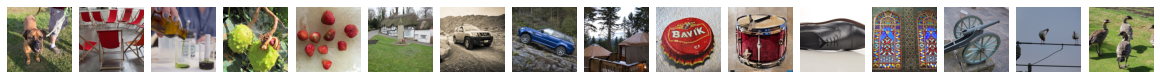

In [15]:
fb.plot.images(images)

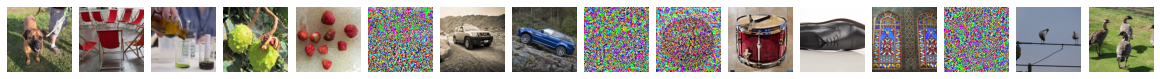

In [17]:
fb.plot.images(raw)

As we can see for overburdening our attack budget, the adversarial perturbations are not imperctible any more which defeats the purpose to some extent. 

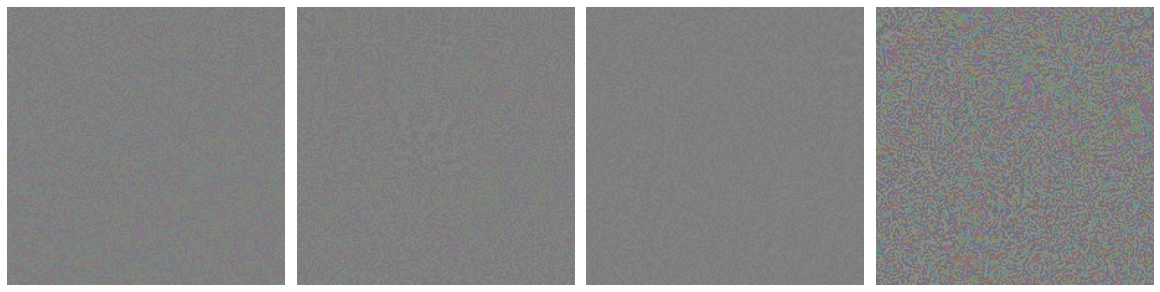

In [19]:
fb.plot.images(raw - images, n=4, bounds=(-0.1, 0.1), scale=4.)

## Robustness as a function of epsilon

$\epsilon$ controls the stength of the generated perturbation. A mode is believed to be more robust when it's able to display consistent performance across different $\epsilon$ values. 

In [21]:
model = ResNet50(weights="imagenet")
pre = dict(flip_axis=-1, mean=[104.0, 116.0, 123.0])  # RGB to BGR
fmodel = fb.TensorFlowModel(model, bounds=(0, 255), preprocessing=pre)
fmodel = fmodel.transform_bounds((0, 1))

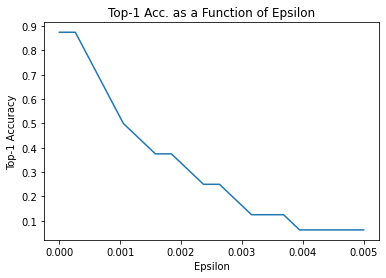

In [27]:
epsilons = np.linspace(0.0, 0.005, num=20)
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
robust_accuracy = 1 - is_adv.numpy().mean(axis=-1)

plt.plot(epsilons, robust_accuracy)
plt.xlabel("Epsilon")
plt.ylabel("Top-1 Accuracy")
plt.title("Top-1 Acc. as a Function of Epsilon")
plt.show()

As we can see the model degrades very quickly. The possibilities with Foolbox are extremely useful for conducting research. You are encouraged to plugin your own models and datasets and verify their robustness using these easy-to-use APIs. You can find all the attacks implemented under Foolbox [here](https://foolbox.readthedocs.io/en/stable/modules/attacks.html). 